In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
import os
import seaborn as sns

2023-04-02 15:42:10.188936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SIZE = 64
images = []
labels = []

for file in glob.glob('./Downsampled/*'):
	if file[-5] == '0':
		labels.append(0)
	else:
		labels.append(1)
	img = cv2.imread(file, cv2.IMREAD_COLOR)
	img = cv2.resize(img, (SIZE,SIZE))
	img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
	images.append(img)

images = np.array(images)
labels = np.array(labels)

x_train = images[:300, :, :, :]/255
y_train = labels[:300]

x_test = images[300:400, :, :, :]/255
y_test= labels[300:400]

In [10]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [11]:
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(batch_normalization.BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(batch_normalization.BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(batch_normalization.BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(batch_normalization.BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

In [12]:
#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(2, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 64, 64, 3)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0   

In [13]:

history = cnn_model.fit(x_train, y_train_one_hot, epochs=50, validation_data = (x_test, y_test_one_hot))

Epoch 1/50
10/10 [==============================] - 10s 939ms/step - loss: 0.6456 - accuracy: 0.9033 - val_loss: 0.6401 - val_accuracy: 0.9200
Epoch 2/50
10/10 [==============================] - 10s 980ms/step - loss: 0.5719 - accuracy: 0.9233 - val_loss: 0.5330 - val_accuracy: 0.9200
Epoch 3/50
10/10 [==============================] - 9s 878ms/step - loss: 0.4700 - accuracy: 0.9233 - val_loss: 0.4258 - val_accuracy: 0.9200
Epoch 4/50
10/10 [==============================] - 9s 947ms/step - loss: 0.3760 - accuracy: 0.9233 - val_loss: 0.3450 - val_accuracy: 0.9200
Epoch 5/50
10/10 [==============================] - 9s 929ms/step - loss: 0.3071 - accuracy: 0.9233 - val_loss: 0.2914 - val_accuracy: 0.9200
Epoch 6/50
10/10 [==============================] - 9s 918ms/step - loss: 0.2771 - accuracy: 0.9233 - val_loss: 0.2789 - val_accuracy: 0.9200
Epoch 7/50
10/10 [==============================] - 10s 987ms/step - loss: 0.2722 - accuracy: 0.9233 - val_loss: 0.2815 - val_accuracy: 0.9200
Epo

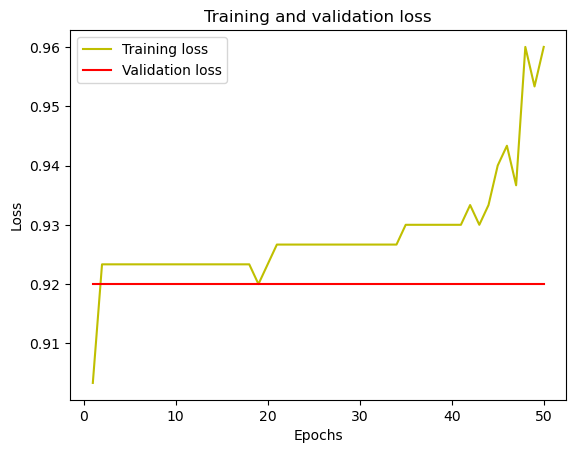

In [15]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

4/4 [==============================] - 1s 173ms/step
[[92  0]
 [ 8  0]]


<AxesSubplot: >

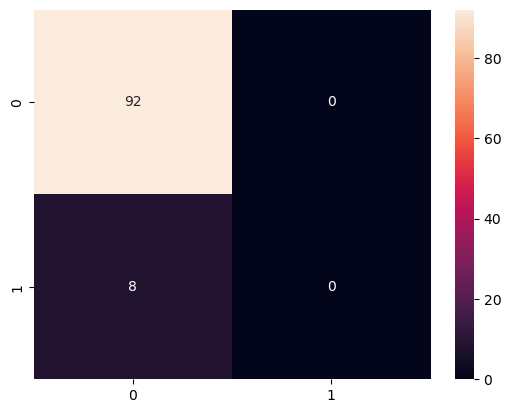

In [16]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True)

In [17]:
#Now, let us use features from convolutional network for RF
X_for_RF = feature_extractor.predict(x_train) #This is out X input to RF

10/10 [==============================] - 2s 216ms/step


In [19]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

4/4 [==============================] - 1s 193ms/step
Accuracy =  0.94


<AxesSubplot: >

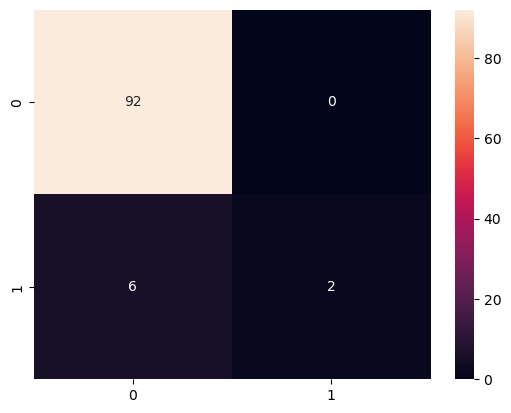

In [20]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)